Chapter 2 Derivatives and Gradients
========

2.1 Example - Symbolic differentiation provides analytical derivatives.
----

In [1]:
import sympy as sp

In [2]:
x = sp.symbols('x')
f = x**2 + x/2 - sp.sin(x)/x
f_prime = sp.diff(f, x)

In [3]:
print("Function:")
sp.pprint(f)
print("\nDerivative:")
sp.pprint(f_prime)

Function:
 2   x   sin(x)
x  + ─ - ──────
     2     x   

Derivative:
      1   cos(x)   sin(x)
2⋅x + ─ - ────── + ──────
      2     x         2  
                     x   


2.3.1 Finite Difference Methods
----

In [4]:
import numpy as np

In [5]:
def diff_forward(f, x, h=1e-9):
    return (f(x + h) - f(x)) / h

def diff_central(f, x, h=1e-9):
    return (f(x + h/2) - f(x - h/2)) / h

def diff_backward(f, x, h=1e-9):
    return (f(x) - f(x - h)) / h

In [6]:
# Differentiate a sample function
f = np.sin
x = 1.0
h = 0.1  # Use a larger h to see differences

# Calculate derivatives 
print(f"Forward:  {diff_forward(f, x=x, h=h):.4f}")
print(f"Central:  {diff_central(f, x=x, h=h):.4f}")
print(f"Backward: {diff_backward(f, x=x, h=h):.4f}")
print(f"True:     {np.cos(x== 1.0):.4f}")

Forward:  0.4974
Central:  0.5401
Backward: 0.5814
True:     0.5405


2.3.2 Complex Methods
-----

In [7]:
def f(x):
    return np.sin(x**2)

x = np.pi / 2
h = 0.001
complex_input = x + h * 1j
v = f(complex_input)

In [8]:
f_x = v.real
print(f"f(x) ≈ {f_x:.4f}")

f_prime_x = v.imag / h
print(f"f'(x) ≈ {f_prime_x:.4f}")

f(x) ≈ 0.6243
f'(x) ≈ -2.4543


2.5 Example - An implementation of dual numbers that allows for automatic forward accumulation.
-----

In [9]:
import math

In [10]:
class Dual:
    """Dual number for automatic differentiation"""
    def __init__(self, v, d):
        self.v = v  # Real part
        self.d = d  # Dual part (derivative)
    
    def __add__(self, other):
        return Dual(self.v + other.v, self.d + other.d)
       
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):
        return Dual(self.v * other.v, self.v * other.d + other.v * self.d)
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __repr__(self):
        return f"Dual({self.v}, {self.d})"

def log_dual(a):
    """Logarithm for dual numbers"""
    return Dual(math.log(a.v), a.d / a.v)
        
def max_dual(a, b):
    """Maximum for dual numbers"""
    if isinstance(a, Dual) and isinstance(b, Dual):
        v = a.v if a.v > b.v else b.v
        if a.v > b.v:
            d = a.d
        elif a.v < b.v:
            d = b.d
        else:
            d = float('nan')
        return Dual(v, d)
    elif isinstance(a, Dual):
        v = a.v if a.v > b else b
        if a.v > b:
            d = a.d
        elif a.v < b:
            d = 0
        else:
            d = float('nan')
        return Dual(v, d)

In [11]:
# Example
a = Dual(3, 1)
b = Dual(2, 0)
print(log_dual(a * b + max_dual(a, 2)))  

Dual(2.1972245773362196, 0.3333333333333333)


Algorithm 2.3
----

In [12]:
import plotly.graph_objects as go

In [13]:
def regression_gradient(f, x, m, delta):
    fx = f(x)
    n = len(x)
    
    # Generate random perturbations
    random_matrix = np.random.randn(m, n) 
    # Normalize them
    delta_x = np.array([delta * (row / np.linalg.norm(row)) for row in random_matrix]) 
    
    # Compute function differences
    delta_f = np.array([f(x + delta_x) - fx for delta_x in delta_x])
    
    # Solve least squares: delta_x \ delta_f
    gradient = np.linalg.lstsq(delta_x, delta_f, rcond=None)[0]
    
    return gradient

### Create figure described in book

In [16]:
# Define a saddle surface function
def f(x):
    return np.cos(x[0]) / np.sin(x[1])

# Evaluate at x = [1.5, 2.5] with m = 20 samples
x_eval = np.array([1.5, 2.5])
m = 20
delta = 0.01

# Compute gradient using regression method
grad_estimated = regression_gradient(f, x_eval, m, delta)

# Create meshgrid for surface plot
x1_range = np.linspace(0.5, 2.5, 50)
x2_range = np.linspace(1.5, 3.5, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = np.cos(X1) / np.sin(X2)

# Perform gradient descent using the regression gradient
x_current = x_eval.copy()
trajectory = [x_current.copy()]
learning_rate = 0.05
n_steps = 30

for i in range(n_steps):
    grad = regression_gradient(f, x_current, m=20, delta=0.01)
    x_current = x_current - learning_rate * grad
    # Keep within bounds
    x_current[0] = np.clip(x_current[0], 0.5, 2.5)
    x_current[1] = np.clip(x_current[1], 1.5, 3.5)
    trajectory.append(x_current.copy())

trajectory = np.array(trajectory)

# Get z values for trajectory
z_trajectory = [f(point) for point in trajectory]

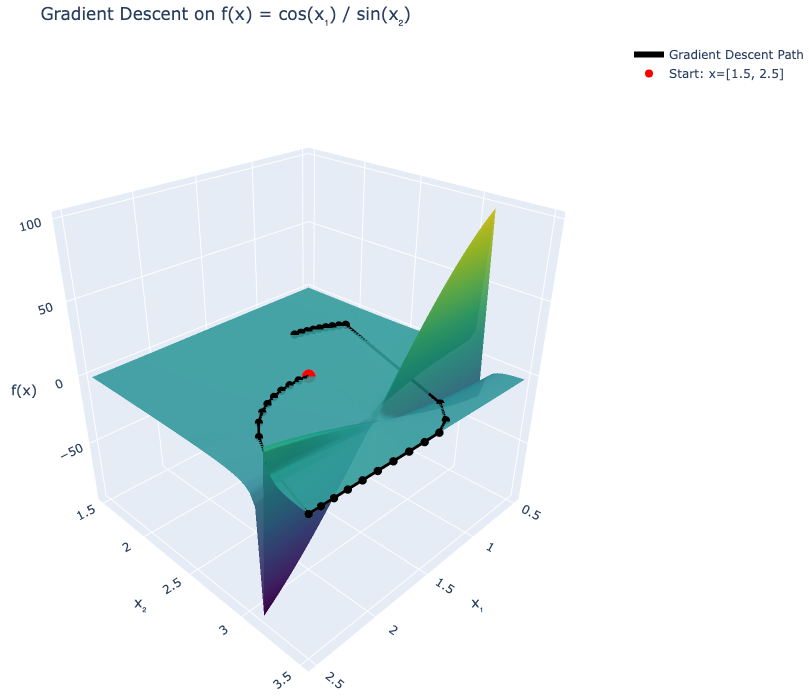

In [17]:
# Create figure
fig = go.Figure()

# Add surface
fig.add_trace(go.Surface(
    x=X1, y=X2, z=Z,
    colorscale='Viridis',
    opacity=0.9,
    showscale=False
))

# Add trajectory line
fig.add_trace(go.Scatter3d(
    x=trajectory[:, 0],
    y=trajectory[:, 1],
    z=z_trajectory,
    mode='lines+markers',
    line=dict(color='black', width=6),
    marker=dict(size=5, color='black'),
    name='Gradient Descent Path'
))

# Add starting point
fig.add_trace(go.Scatter3d(
    x=[x_eval[0]],
    y=[x_eval[1]],
    z=[f(x_eval)],
    mode='markers',
    marker=dict(size=8, color='red', symbol='circle'),
    name='Start: x=[1.5, 2.5]'
))

# Update layout
fig.update_layout(
    title="Gradient Descent on f(x) = cos(x₁) / sin(x₂)",
    scene=dict(
        xaxis=dict(title='x₁'),
        yaxis=dict(title='x₂'),
        zaxis=dict(title='f(x)'),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2)
        )
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

### Create another figure to explore options

In [18]:
# Define saddle surface function
def f(x):
    return x[0]**2 - x[1]**2

In [19]:
# Create meshgrid for surface plot
x_range = np.linspace(-2, 3, 60)
y_range = np.linspace(-2, 3, 60)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 - Y**2

# Perform gradient descent
x_current = np.array([2.0, 2.0])
trajectory = [x_current.copy()]
learning_rate = 0.15
n_steps = 40

for i in range(n_steps):
    grad = regression_gradient(f, x_current, m=20, delta=0.01)
    x_current = x_current - learning_rate * grad
    trajectory.append(x_current.copy())

trajectory = np.array(trajectory)

# Get z values for trajectory
z_trajectory = [f(point) for point in trajectory]


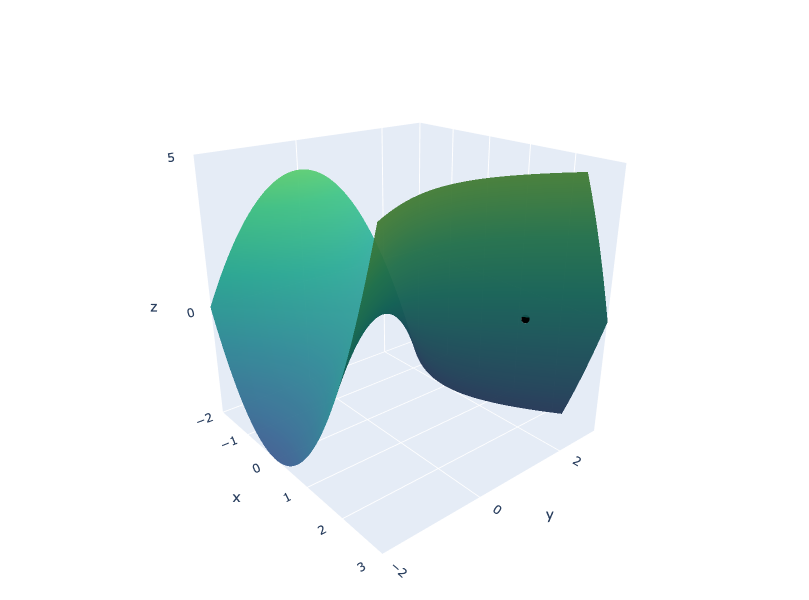

In [20]:
# Create figure
fig = go.Figure()

# Add surface
fig.add_trace(go.Surface(
    x=X, y=Y, z=Z,
    colorscale='Viridis',
    opacity=0.95,
    showscale=False,
    lighting=dict(ambient=0.6, diffuse=0.8, specular=0.2),
    lightposition=dict(x=100, y=200, z=300)
))

# Add trajectory line and markers
fig.add_trace(go.Scatter3d(
    x=trajectory[:, 0],
    y=trajectory[:, 1],
    z=z_trajectory,
    mode='markers',
    marker=dict(size=5, color='black'),
    showlegend=False
))

# Update layout to match the reference figure
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-2, 3], showgrid=True, zeroline=True),
        yaxis=dict(range=[-2, 3], showgrid=True, zeroline=True),
        zaxis=dict(range=[-4, 5], showgrid=True, zeroline=True),
        camera=dict(
            eye=dict(x=1.8, y=-1.5, z=1.0)
        ),
        aspectmode='cube'
    ),
    width=800,
    height=600,
    margin=dict(l=0, r=0, t=0, b=0),
    showlegend=False
)

fig.show()